In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sp
import pymc3 as pm
import matplotlib.pyplot as plt
from matplotlib.cm import Blues

plt.style.use('seaborn-whitegrid')

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


![EFZD7ytWwAArRZY.jpeg](EFZD7ytWwAArRZY.jpeg)

In [2]:
data = pd.Series([18, 19, 22, float('nan'), float('nan'), 19, 20, 22])
data

0    18.0
1    19.0
2    22.0
3     NaN
4     NaN
5    19.0
6    20.0
7    22.0
dtype: float64

In [3]:
mean_ = data.sum() / 6.

# Unknown dice: noninformative prior

We set a prior for the dice to be a Diriclect distribution with a flat concentration:

$$ \mathbf{p} \sim \text{Diriclet}(\frac{\mathbf{I}}{8}) $$

We then impute the missing values for the third and fourth rolls with draws from the Poisson distribution with the raw mean as the prior:

$$ n_{3,4} \sim \text{Poisson}(mean) $$

The total observations is then the total counts of the noted sides plus the imputed:

$$ N = \sum_{i=0}^{7}{n_i} $$

Finally, as likelihood, we use the multinomial distribution:

$$ \mathbf{n} \sim \text{Multinomial}(\mathbf{p}, N) $$

In [4]:
with pm.Model() as m1:
    p = pm.Dirichlet('p', np.ones(8) / 8., shape=8)

    n3 = pm.Poisson('n3', mu=mean_)
    n4 = pm.Poisson('n4', mu=mean_)
    N = pm.Deterministic('N', data.sum() + n3 + n4)

    obs_data = list(data)
    obs_data[3] = n3
    obs_data[4] = n4
    obs_data = pm.math.stack(obs_data)
    obs_data = pm.Deterministic('obs_data', obs_data)

    succ = pm.Multinomial('succ', n=N, p=p, observed=obs_data)

    m1.name = 'm1'
    m1.trace = pm.sample(5000, tune=5000, chains=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [p]
>CompoundStep
>>Metropolis: [n4]
>>Metropolis: [n3]
Sampling 2 chains: 100%|██████████| 20000/20000 [00:40<00:00, 498.28draws/s]
The number of effective samples is smaller than 25% for some parameters.


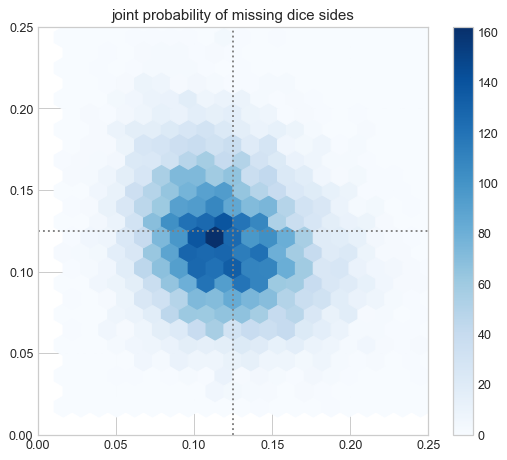

In [5]:
plt.figure(figsize=(7, 6), dpi=90)
plt.hexbin(m1.trace['p'][:, 3], m1.trace['p'][:, 4], gridsize=23, cmap=Blues)
plt.axvline(1./8, linestyle=':', color='gray')
plt.axhline(1./8, linestyle=':', color='gray')
plt.gca().set(title='joint probability of missing dice sides',
              xlim=(0, 0.25), ylim=(0, 0.25))
plt.colorbar()
None

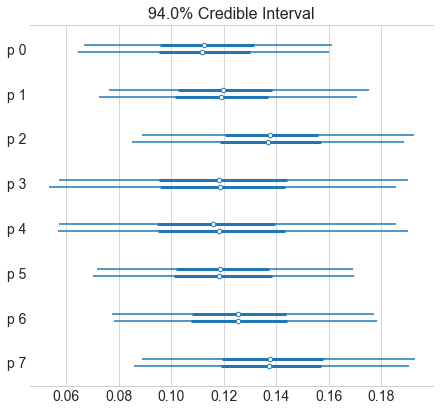

In [6]:
pm.plot_forest(m1.trace, var_names=['p'])
None

In [7]:
with m1:
    m1.ppc = pm.sample_posterior_predictive(m1.trace, 50000, vars=[n3, n4])

100%|██████████| 50000/50000 [00:02<00:00, 19650.74it/s]


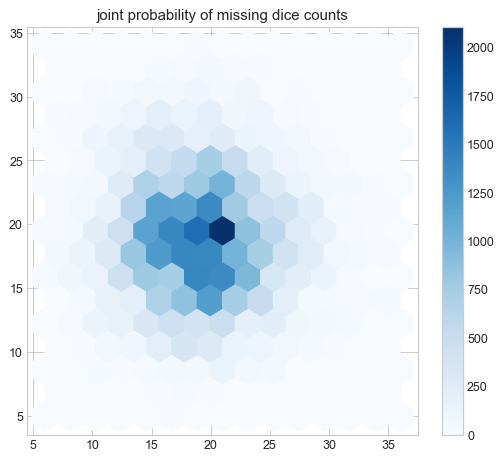

In [8]:
plt.figure(figsize=(7, 6), dpi=90)
plt.hexbin(m1.ppc['n3'], m1.ppc['n4'], gridsize=14, cmap=Blues)
plt.gca().set(title='joint probability of missing dice counts')
plt.colorbar()
None

# Fair dice

In [9]:
with pm.Model() as m2:
    p = np.ones(8) / 8.

    n3 = pm.Poisson('n3', mu=mean_)
    n4 = pm.Poisson('n4', mu=mean_)
    N = pm.Deterministic('N', data.sum() + n3 + n4)

    obs_data = list(data)
    obs_data[3] = n3
    obs_data[4] = n4
    obs_data = pm.math.stack(obs_data)
    obs_data = pm.Deterministic('obs_data', obs_data)

    succ = pm.Multinomial('succ', n=N, p=p, observed=obs_data)

    m2.name = 'm2'
    m2.trace = pm.sample(5000, tune=5000, chains=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [n4]
>Metropolis: [n3]
Sampling 2 chains: 100%|██████████| 20000/20000 [00:06<00:00, 3009.09draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [10]:
with m2:
    m2.ppc = pm.sample_posterior_predictive(m2.trace, 50000, vars=[n3, n4])

100%|██████████| 50000/50000 [00:02<00:00, 20276.00it/s]


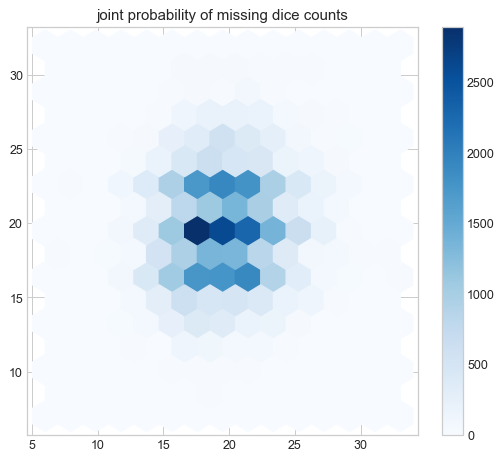

In [11]:
plt.figure(figsize=(7, 6), dpi=90)
plt.hexbin(m2.ppc['n3'], m2.ppc['n4'], gridsize=14, cmap=Blues)
plt.gca().set(title='joint probability of missing dice counts')
#               xlim=(0, 38), ylim=(0, 38))
plt.colorbar()
None

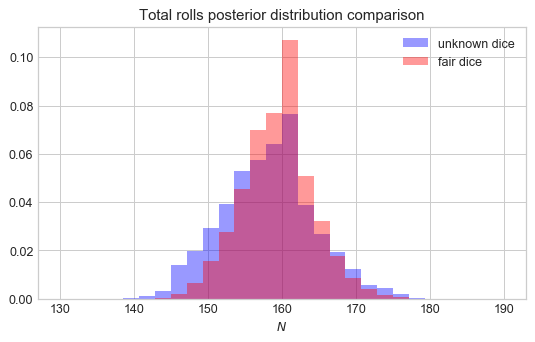

In [12]:
bins = np.linspace(130, 190, 29)
plt.figure(figsize=(7, 4), dpi=90)
plt.hist(m1.trace['N'], alpha=.4, bins=bins, density=True,
         label='unknown dice', color='b')
plt.hist(m2.trace['N'], alpha=.4, bins=bins, density=True,
         label='fair dice', color='r')
plt.legend()
plt.gca().set(title='Total rolls posterior distribution comparison',
              xlabel='$N$')
None